In [1]:
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/wsl/lib'

In [2]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation, ObservationLong
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.beam import BeamPattern
from karabo.sourcedetection.result import SourceDetectionResult, PyBDSFSourceDetectionResult
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from karabo.simulation.visibility import Visibility
# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


In [3]:
def create_random_sources(num_sources, ranges):
    """
    Create a random set of sources.

    :param num_sources: number of sources to create
    :param ranges: list of ranges for each parameter. 
    
    Description of ranges:

    - [0] right ascension (deg)-
    - [1] declination (deg)
    - [2] stokes I Flux (Jy)
    - [3] stokes Q Flux (Jy): defaults to 0
    - [4] stokes U Flux (Jy): defaults to 0
    - [5] stokes V Flux (Jy): defaults to 0
    - [6] reference_frequency (Hz): defaults to 0
    - [7] spectral index (N/A): defaults to 0
    - [8] rotation measure (rad / m^2): defaults to 0
    - [9] major axis FWHM (arcsec): defaults to 0
    - [10] minor axis FWHM (arcsec): defaults to 0
    - [11] position angle (deg): defaults to 0
    - [12] source id (object): defaults to None
    """

    sources = np.column_stack(
        (
            np.random.uniform(min_val, max_val, num_sources)
            for min_val, max_val in ranges
        )
    )

    return sources


/tmp/ipykernel_29562/1059202742.py:25: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  sources = np.column_stack(


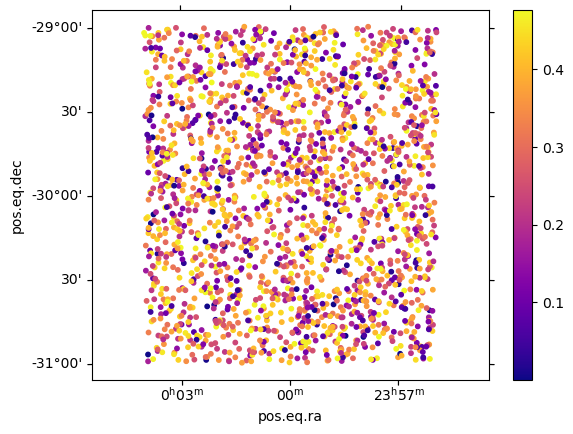

In [4]:
sky = SkyModel()
sky_data = create_random_sources(2028, [[-1, 1], [-29, -31], [1, 3], [0, 2], [0, 2], [0, 2], [100.0e6, 100.0e6], [-0.7, -0.7], [0.0, 0.0], [0, 600], [50, 50], [45, 45]])
sky.add_point_sources(sky_data)
sky.explore_sky([0, -30], s=10)

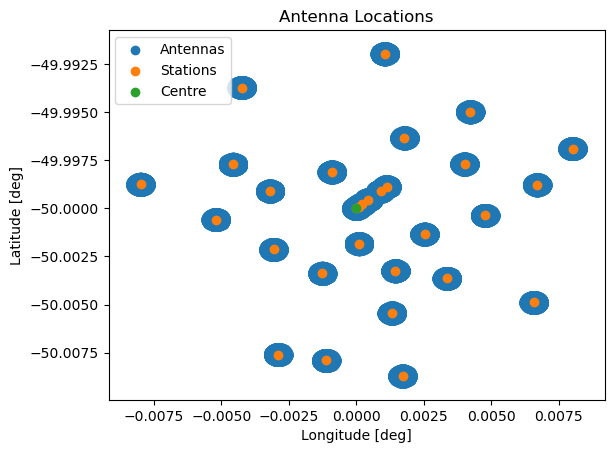

In [5]:
telescope = Telescope.get_OSKAR_Example_Telescope()
telescope.plot_telescope()

In [6]:
def observation_length_integration_time_to_time_steps(observation_length, integration_time):
    return int(observation_length.total_seconds() / integration_time.total_seconds())

def time_observation_long(total_observation_length, daily_observation_length, integration_time):
    number_of_days = int(total_observation_length.total_seconds() / daily_observation_length.total_seconds())
    
    observation_long = ObservationLong(
        # length=4 hours
        start_frequency_hz=100e6,
        phase_centre_ra_deg=0,
        phase_centre_dec_deg=-30,
        number_of_channels=2,
        number_of_time_steps=observation_length_integration_time_to_time_steps(daily_observation_length, integration_time),
        number_of_days=number_of_days,
        length=timedelta(hours=4),
    )
    xcstfile_path = "cst_like_beam_port_1.txt"

    ycstfile_path = "cst_like_beam_port_2.txt"
    beam_polX = BeamPattern(
        cst_file_path=xcstfile_path,
        telescope=telescope,
        freq_hz=observation_long.start_frequency_hz,
        pol="X",
        avg_frac_error=0.8,
        beam_method="Gaussian Beam",
    )
    beam_polY = BeamPattern(
        cst_file_path=ycstfile_path,
        telescope=telescope,
        freq_hz=observation_long.start_frequency_hz,
        pol="Y",
        avg_frac_error=0.8,
        beam_method="Gaussian Beam",
    )
            
    interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e5, vis_path='./data/visibilities.ms', beam_polX=beam_polX, beam_polY=beam_polY)
    visibilities = interferometer_sim.run_simulation(telescope, sky, observation_long)
    combined_vis_filepath = os.path.join("data", "combined_vis.ms")
    Visibility.combine_vis(number_of_days, visibilities, combined_vis_filepath)

In [10]:
tst = {}

tst[(timedelta(hours=1), timedelta(hours=1))] = datetime.now()

In [11]:
pd.DataFrame(tst, index=['time']).T

{(datetime.timedelta(seconds=3600),
  datetime.timedelta(seconds=3600)): datetime.datetime(2023, 2, 23, 11, 52, 48, 381366)}

In [8]:
TOTAL_OBSERVATION_LENGTH = timedelta(hours=2)
DAILY_OBSERVATION_LENGTH = timedelta(hours=1)
INTEGRATION_TIME = timedelta(seconds=10)

In [9]:
%timeit time_observation_long(TOTAL_OBSERVATION_LENGTH, DAILY_OBSERVATION_LENGTH, INTEGRATION_TIME)

use_gpu is None, using is_cuda_available() to set use_gpu to True
Some example files to remove/replace:
['./data/visibilities.ms/beam_vis_0.vis', './data/visibilities.ms/beam_vis_1.vis', './data/visibilities.ms/beam_vis_0.ms', './data/visibilities.ms/beam_vis_1.ms']
Removed 4 file(s) matching the glob pattern "beam_vis_*.vis" and "beam_vis_*.ms"!
Observing Day: 0 the 2023-02-23 10:37:25.484581
./data/visibilities.ms/beam_vis_0.vis
Observing Day: 1 the 2023-02-23 10:37:25.484581
./data/visibilities.ms/beam_vis_1.vis
### Combining the visibilities for  ['./data/visibilities.ms/beam_vis_0.vis', './data/visibilities.ms/beam_vis_1.vis']
### Writing combined visibilities in  data/combined_vis.ms
use_gpu is None, using is_cuda_available() to set use_gpu to True
Some example files to remove/replace:
['./data/visibilities.ms/beam_vis_0.vis', './data/visibilities.ms/beam_vis_1.vis', './data/visibilities.ms/beam_vis_0.ms', './data/visibilities.ms/beam_vis_1.ms']
Removed 4 file(s) matching the glo